In [19]:
import os
from torch.utils.data import Dataset, DataLoader
import re
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from depth_net import DepthV3
from lib.loss_depth import L2Loss, GradientLoss, NormalLoss, BerHu
from torch import optim
import time
import torch

In [29]:
class FaceDepthDataset(Dataset):
    def __init__(self, depth_root, rgb_root, scene_root, data_type='train'):
        start = 1
        end = 69   
        start_scene = 1
        end_scene = 10
        
        if data_type == "val":
            start = 70
            end = 84
            start_scene = 11
            end_scene = 12
            
        if data_type == "test":
            start = 85
            end = 100
            start_scene = 13
            end_scene = 14
            
        self.depth_file_paths = []
        self.rgb_file_paths = []
        count = 0
        for person in os.listdir(depth_root):
            if int(person) >= start and int(person) <= end:
                depth_folder = os.path.join(depth_root, person)
                for img in os.listdir(depth_folder):
                    frame_number_regex = re.search('frame_(.*)_face', img)
                    if frame_number_regex:
                        count += 1
                        if count % 3 == 0:
                            frame_number = frame_number_regex.group(1)
                            self.depth_file_paths.append(os.path.join(depth_root, 
                                                                 person, 
                                                                 "frame_%s_face_depth.png" % frame_number))
                            self.rgb_file_paths.append(os.path.join(rgb_root, 
                                                               person, 
                                                                 "frame_%s_face_rgb.png" % frame_number))
                            
        for scene in os.listdir(scene_root):
            if ".ipynb" not in scene:
                scene_number_regex = re.search('scene_(.*)', scene)
                if scene_number_regex:
                    scene_number = int(scene_number_regex.group(1))
                    if scene_number >= start_scene and scene_number <= end_scene:
                        if scene_number < 10:
                            scene_folder = "scene_0" + str(scene_number)
                        else:
                            scene_folder = "scene_" + str(scene_number)
                        
                        for img_path in os.listdir(os.path.join(scene_root, scene_folder)):
                            if "color" in img_path:
                                img_regex = re.search('(.*)-color', img_path)
                                if img_regex:
                                    img_num = img_regex.group(1)
                                    depth_img_path = os.path.join(scene_root, scene_folder, img_num + "-depth.png") 
                                    rgb_img_path = os.path.join(scene_root, scene_folder, img_num + "-color.png") 
                                    self.depth_file_paths.append(depth_img_path)
                                    self.rgb_file_paths.append(rgb_img_path)
      
                    
    def __len__(self):
        return len(self.depth_file_paths)
    
    def __getitem__(self, idx):
        depth_img = Image.open(self.depth_file_paths[idx])
        rgb_img = Image.open(self.rgb_file_paths[idx])

        rgb_img = transforms.Compose([
            transforms.ColorJitter([0.6, 1.4], [0.6, 1.4], [0.6, 1.4])
        ])(rgb_img)
        
        
        rgb_img = TF.resize(rgb_img, 100)
        rgb_img = TF.center_crop(rgb_img, 100)
        
        depth_img = TF.resize(depth_img, 100)
        depth_img = TF.center_crop(depth_img, 100)
        
        
        # Random horizontal flip
        if random.random() > 0.5:
            depth_img = TF.hflip(depth_img)
            rgb_img = TF.hflip(rgb_img)
        
        choice = random.randint(0, 3)
        depth_img = TF.rotate(depth_img, choice * 90)
        rgb_img = TF.rotate(rgb_img, choice * 90)

        depth_img = TF.to_tensor(depth_img).float()
        rgb_img = TF.to_tensor(rgb_img).float()
        
        rgb_img = TF.normalize(rgb_img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
        return (rgb_img, depth_img)

In [30]:
depth_root = 'depth_data/depth'
rgb_root = 'depth_data/rgb'
scene_root = "rgbd-scenes-v2/imgs"
train_dataset = FaceDepthDataset(depth_root, rgb_root, scene_root, 'train')
val_dataset = FaceDepthDataset(depth_root, rgb_root, scene_root, 'val')
test_dataset = FaceDepthDataset(depth_root, rgb_root, scene_root, 'test')

In [31]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [32]:
len(train_dataset)

37256

In [33]:
def visualize(rgb_img, depth_img, pred_depth_img):
    depth_img = depth_img.squeeze()
    pred_depth_img = pred_depth_img.squeeze()
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

    rgb_img = inv_normalize(rgb_img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    ax1.imshow(rgb_img.permute(1, 2, 0))
    ax1.axis('off')
    
    ax2.imshow(depth_img, cmap='Spectral')
    ax2.axis('off')
    
    ax3.imshow(pred_depth_img, cmap='Spectral')
    ax3.axis('off')
    plt.show()

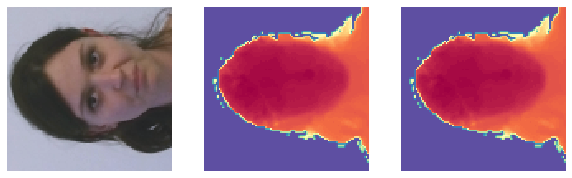

In [34]:
for i, batch in enumerate(train_loader):
    rgb_img = batch[0][0]
    depth_img = batch[1][0]

    visualize(rgb_img, depth_img, depth_img)
    break

In [35]:
estimator = DepthV3((100, 100))
estimator.cuda();

In [36]:
lr = 0.00005
optimizer = optim.Adam(estimator.parameters(), lr=lr)
# optimizer = optim.SGD(estimator.parameters(), lr, momentum=0.9, weight_decay=1e-4)

lossGrad = GradientLoss()
lossNormal = NormalLoss()
berhu = BerHu()

In [37]:
start_epoch = 2
end_epoch = 20

In [38]:
# Reduce the learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.3

In [39]:
st_time = time.time()
for epoch in range(start_epoch, end_epoch):
    mess = 'Train time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + ', ' + 'Training started')
    print(mess)
    
    train_count = 0
    loss_avg = 0.0
    loss_berhu_avg= 0.0
    loss_normal_avg = 0.0
    loss_grad_avg = 0.0
    train_loss_avg = 0.0
    estimator.train()
    optimizer.zero_grad()
    
    for i, data in enumerate(train_loader):
        rgbs, depths = data
        rgbs, depths = rgbs.float().cuda(), depths.float().cuda()
        
        pred_depths = estimator(rgbs)
        
        loss_Berhu = berhu(pred_depths, depths) 
        loss_grad = lossGrad(pred_depths, depths) 
        loss_normal = lossNormal(pred_depths, depths) 
        total_loss = loss_Berhu + loss_normal + loss_grad
        
        total_loss.backward()
        

        loss_avg = total_loss.item()
        loss_berhu_avg = loss_Berhu.item()
        loss_normal_avg = loss_normal.item()
        loss_grad_avg = loss_grad.item()
        train_loss_avg = total_loss.item()
        train_count += batch_size
        
        optimizer.step()
        optimizer.zero_grad()
        
        if train_count % (batch_size * 20) == 0:
            mess = 'Train time {0} Epoch {1} Batch {2} Frame {3}\nAvg_loss: {4:.6f} loss_l2: {5:.6f} loss_grad: {6:.6f} loss_normal: {7:.6f}'.format(
                                time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), 
                                epoch, int(train_count / batch_size), 
                                train_count, 
                                loss_avg, 
                                loss_berhu_avg, 
                                loss_grad_avg, 
                                loss_normal_avg)
            print(mess)
        
        if train_count != 0 and train_count % ( batch_size * 200) == 0:                    
            rgb_img = rgbs[0].cpu().detach()
            depth_img = depths[0].cpu().detach()
            pred_depth_img = pred_depths[0].cpu().detach()
            visualize(rgb_img, depth_img, pred_depth_img)
            
            torch.save(estimator.state_dict(), 'models/depth_model_current.pth')
        
    print('>>>>>>>>----------epoch {0} train finish---------<<<<<<<<'.format(epoch))
    
    test_loss = 0.0
    test_count = 0
    estimator.eval()
    plot = True
    
    for j, data in enumerate(val_loader):
        rgbs, depths = data
        rgbs, depths = rgbs.float().cuda(), depths.float().cuda()
        
        pred_depths = estimator(rgbs)
        
        loss_Berhu = berhu(pred_depths, depths) 
        loss_grad = lossGrad(pred_depths, depths) 
        loss_normal = lossNormal(pred_depths, depths) 
        total_loss = loss_Berhu + loss_normal + loss_grad
        
        test_loss += total_loss.item()
        test_count += 1
    
    
        
        if plot:
            rgb_img = rgbs[0].cpu().detach()
            depth_img = depths[0].cpu().detach()
            pred_depth_img = pred_depths[0].cpu().detach()
            visualize(rgb_img, depth_img, pred_depth_img)
            plot = False
            
    test_loss = test_loss / test_count    
    mess = 'Test time {0} Epoch {1} TEST FINISH Avg loss: {2}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), epoch, test_loss)
    print(mess)
        
    torch.save(estimator.state_dict(), 'models/depth_model_{0}_{1}.pth'.format(epoch, test_loss))
    print(epoch, '>>>>>>>>----------MODEL SAVED---------<<<<<<<<')
    
    

Train time 00h 00m 00s, Training started


/home/aquancva/.conda/envs/recvis/lib/python3.6/site-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train time 00h 00m 08s Epoch 2 Batch 20 Frame 320
Avg_loss: 4691.160156 loss_l2: 4688.980957 loss_grad: 1.962376 loss_normal: 0.216672
Train time 00h 00m 16s Epoch 2 Batch 40 Frame 640
Avg_loss: 2593.812012 loss_l2: 2592.634277 loss_grad: 1.034770 loss_normal: 0.143171


KeyboardInterrupt: 

# Evaluate

In [27]:
class FaceDataset(Dataset):
    def __init__(self, data_root):   
        self.samples = []
        for img in os.listdir(data_root):
            if ".ipynb" not in img:
                img_path = os.path.join(data_root, img)
                self.samples.append(img_path)
                    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img = Image.open(self.samples[idx])

        img = TF.resize(img, 100)
        img = TF.center_crop(img, 100)
        img = TF.to_tensor(img)
        
        img = TF.normalize(img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
        return img

In [28]:
face_dataset = FaceDataset("input/content")
face_loader = DataLoader(face_dataset, batch_size=1, shuffle=True, num_workers=2)

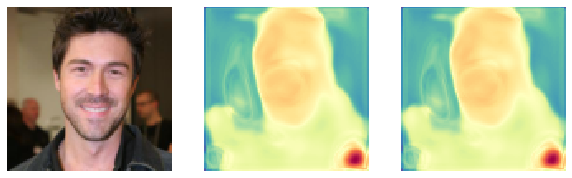

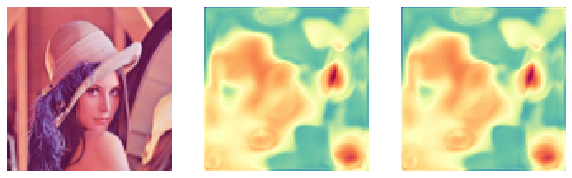

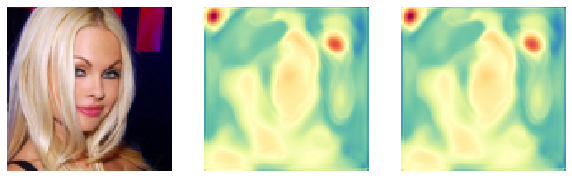

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


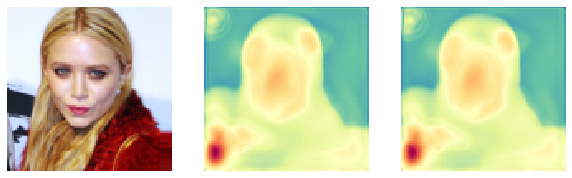

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


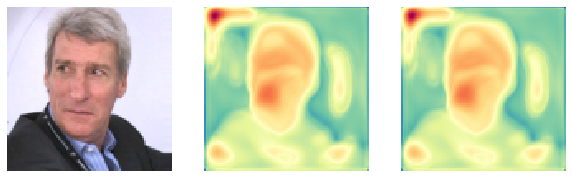

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


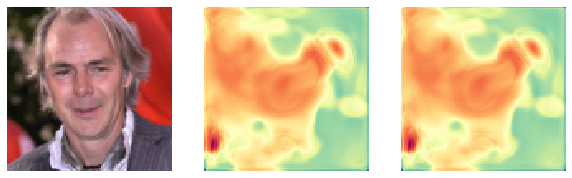

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


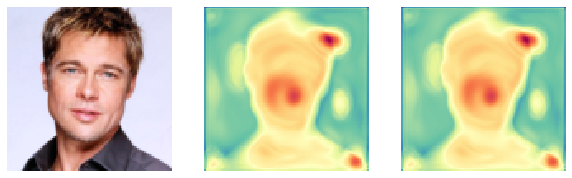

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


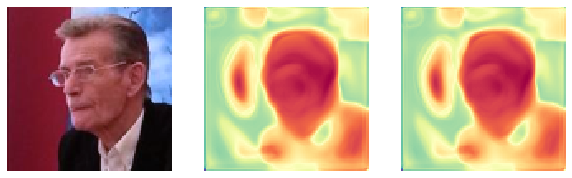

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


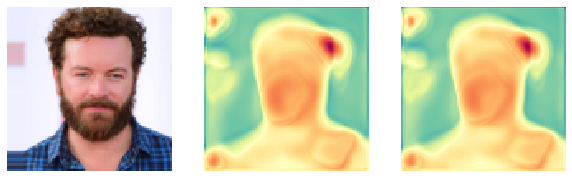

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


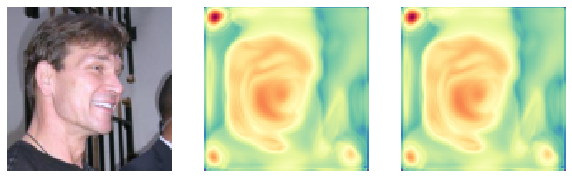

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


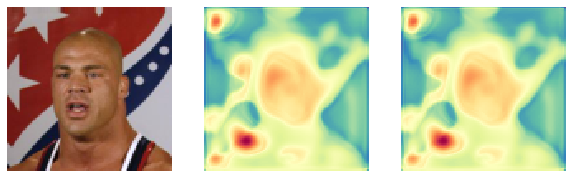

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


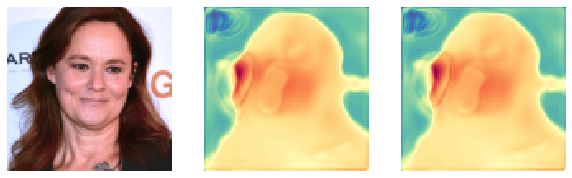

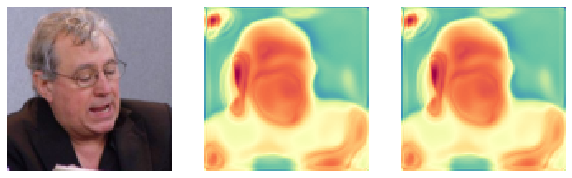

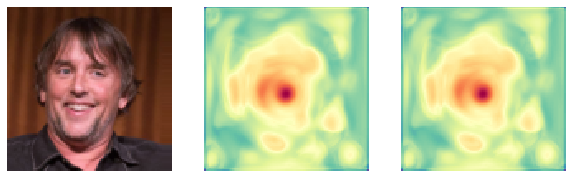

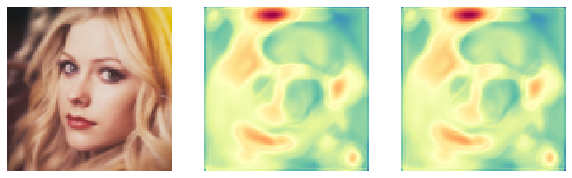

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


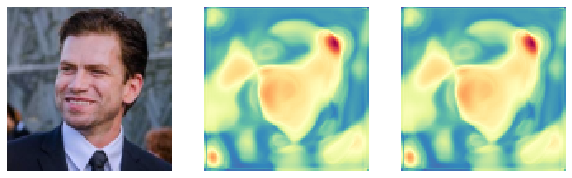

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


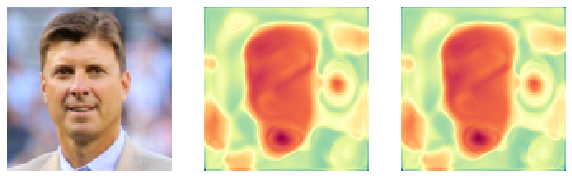

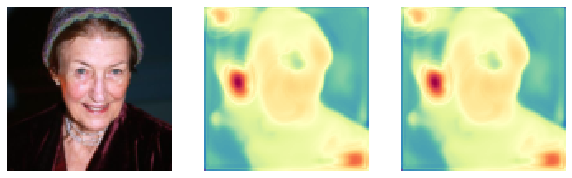

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


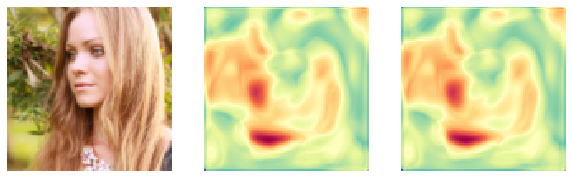

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


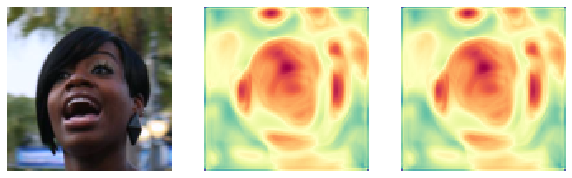

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


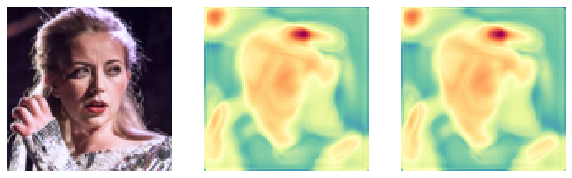

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


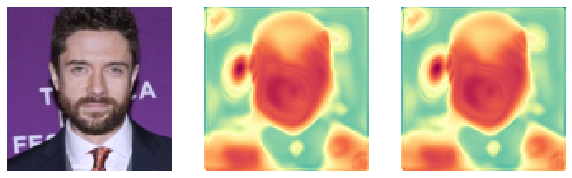

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


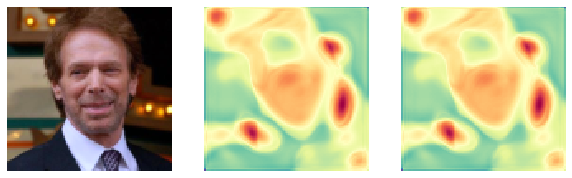

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


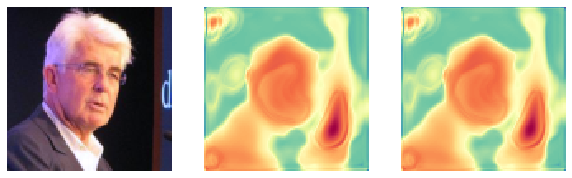

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


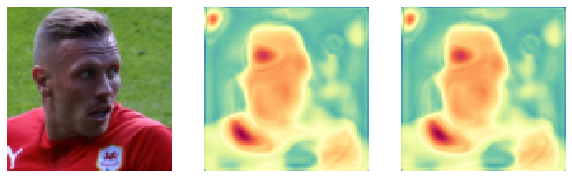

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


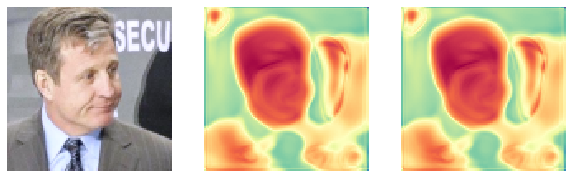

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


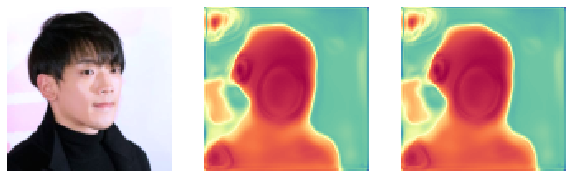

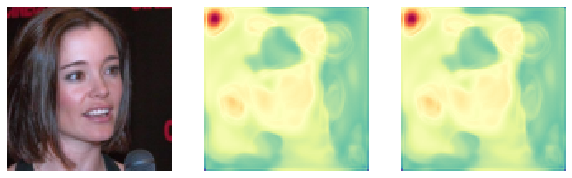

In [29]:
for i, img in enumerate(face_loader):
    img = img.cuda()
    pred_depth = estimator(img)
    rgb_img = img[0].cpu().detach()
    pred_depth_img = pred_depth[0].cpu().detach()
    visualize(rgb_img, pred_depth_img, pred_depth_img)